### Description

The function `event_plot` takes in an `event_id`, as well as various boolean inputs (`aux_incl`, `show_sensors`, `show_true_direction`) and plots the event with the relevant parameters. 

Events are plotted as follows: for each sensor, the size of the plotted point is equal to the total charge (sum of all charges of each time this particular sensor was activated, i.e. sum of all charges of each pulse at that center); the plotted point is colored by the time of the *first* registered pulse for that sensor. 

Fun-looking event IDs: 79, 131158, 917609 (these have no real practical relevance, they're just pretty)

Below we list examples which are either cascade/through-going

Cascade: 79, 131158, 917609

Through-going: 

IDK: 140

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Uncomment to toggle interactivity of matplotlib plots
%matplotlib notebook

In [3]:
# Load data
batch1 = pd.read_parquet('../batches_train/batch_1_repartitions/part.0.parquet')
sensor_geom = pd.read_csv('../sensor_geometry.csv')
event_ids = list(set(batch1.index))

In [4]:
# Load metadata
# meta = pd.read_parquet('../batches_train/train_meta.parquet/')

In [5]:
# Make a function that outputs (x,y,z) for a sensor_id input
def id_to_xyz(sen):
    row = tuple(sensor_geom.loc[sen][1:4])
    return row

In [6]:
def event_plot(eventid, 
               aux_incl=False, 
               show_sensors=True,
               show_true_direction=False):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    event = batch1.loc[eventid]
    scale = 600
    
    # Aux false or both?
    if aux_incl==False:
        event = event[event.auxiliary==False]
    else:
        pass
    
    # Each sensor will register one point; total charge (sum over all 
    # times that sensor registered a charge) corresponds to size in plot
    sensors_and_charge = event.groupby('sensor_id').sum()['charge']
    sensors = np.array(sensors_and_charge.index)
    
    # Cartesian coords of sensors to plot
    xs = [id_to_xyz(s)[0] for s in sensors]
    ys = [id_to_xyz(s)[1] for s in sensors]
    zs = [id_to_xyz(s)[2] for s in sensors]
    
    # Sizes computed from values in sensors_and_charge 
    sizes = sensors_and_charge.values
    
    # Times are computed by first time sensor registered a pulse
    times = [event[event.sensor_id==s].time.values[0] for s in sensors]

    # This scatter plots the sensor pulses
    im = ax.scatter(xs, ys, zs,
                    c=times,
                    cmap='rainbow_r',
                    s=10*sizes,
                    zorder=2,
                    label='pulse',
                    alpha=1)
    
    # This plots the sensors
    if show_sensors==True:
        ax.scatter(sensor_geom.x, sensor_geom.y, sensor_geom.z,
                   c='0.1',
                   alpha=0.03,
                   s=0.5,
                   zorder=1)
        
    # This plots the true direction
    if show_true_direction==True:
        try: 
            df = meta[meta.event_id==eventid]
            az = df.azimuth.iloc[0]
            ze = df.zenith.iloc[0]
            xhat = np.cos(az)*np.sin(ze)
            yhat = np.sin(az)*np.sin(ze)
            zhat = np.cos(ze)
            
            xdir = scale*xhat
            ydir = scale*yhat
            zdir = scale*zhat
            
            xs = [0, xdir]
            ys = [0, ydir]
            zs = [0, zdir]
            
            ax.plot(xs, ys, zs, 
                    '--',
                    c='red',
                    linewidth=0.75,
                    label='true direction',
                    zorder=0)
            
        except NameError:
            print("WARNING: 'meta' undefined")
            print("Did you load meta data and name it 'meta'?")
        

    # Color bar, legend, other niceties
    plt.colorbar(im,
                 orientation='vertical', 
                 label='Nanoseconds passed in event',
                 location='left',
                 fraction=0.02, 
                 pad=0.1)
    
    plt.title("Neutrino event " + str(eventid) + ", aux = " + str(aux_incl),
              fontsize=12)
    plt.legend(loc=(-0.3,0.9))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    ax.view_init(30,-45)
    
    ax.grid(False)

    plt.show()

<IPython.core.display.Javascript object>


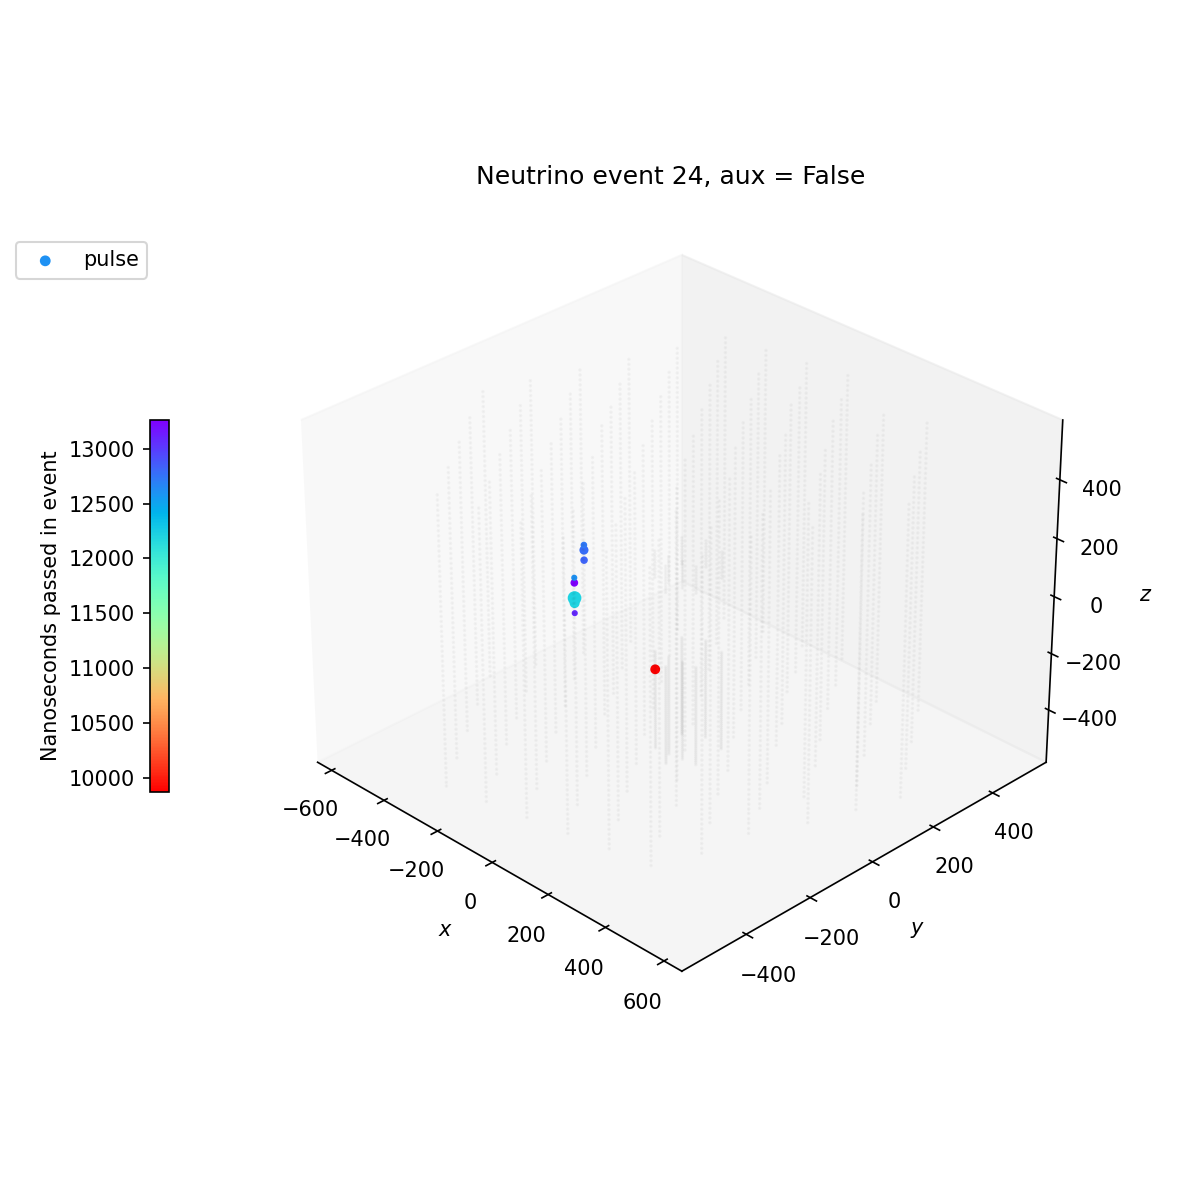

Did you load meta data and name it 'meta'?


In [10]:
event_plot(24, show_sensors=True, aux_incl=False, show_true_direction=True)